## Example input
```
k: #particle name
  corr_file: "D200_rebin10_k0_fit.dat" #fit data points
  tmin_fits:
    single-exp: "D200_rebin10_k0_1exp.dat" #tmin fits
    double-exp: "D200_rebin10_k0_2exp.dat"
    geometric: "D200_rebin10_k0_geom.dat"
  tmin: 8 #final fit tmin
  tmax: 25 #all fit tmaxs
  fit_choice: "double-exp" #final fit form (in current setup, must be double-exp)
  energy: 0.156382648233 #final fit energy
  amp: 609.718319246 #final fit amp
  cont_energy: 0.529576864862 #final fit contamination energy
  cont_rat: 0.376768393109  #final fit contamination amp
  chisqrdof: 1.45 #final fit quality
```

In [1]:
import numpy as np
import h5py
import os, sys
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
import yaml
import argparse

sys.path.append('../')
import utils
import settings
plt.style.use('../spectrum.mplstyle')
eff = r"\textup{eff}"

In [2]:
def double(t, A, E, R, D):
    return A*np.exp(-E*t)*(1.0+R*np.exp(-D*D*t))
def dtdouble(t, A, E, R, D):
    return -E*A*np.exp(-E*t)*(1.0+R*np.exp(-D*D*t))+A*np.exp(-E*t)*(-D*D*R*np.exp(-D*D*t))
def eff(t, A, E, R, D):
    return -dtdouble(t, A, E, R, D)/double(t, A, E, R, D)

In [3]:
with open('D200_rest_mass_info.yml', 'r') as file:
    data_info = yaml.load(file, Loader=yaml.FullLoader)

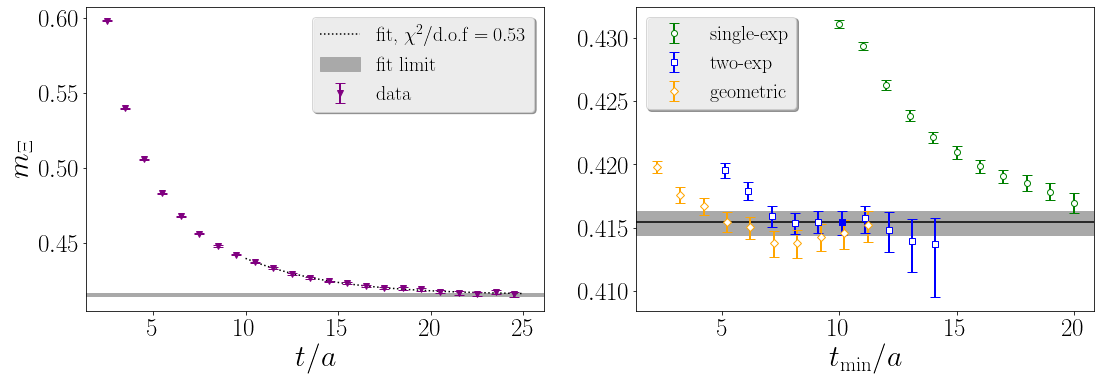

In [4]:
separate = True
if separate:
    f, (ax1, ax2) = plt.subplots(1,2)
    f.set_figheight(6)
else:
    f, axes = plt.subplots(len(data_info),2)
    f.set_figheight(6*(len(data_info)-1))
f.set_figwidth(16)
for j,data in enumerate(data_info.keys()):
    if separate:
        ax1.clear()
        ax2.clear()
    else:
        ax1 = axes[j][0]
        ax2 = axes[j][1]
    
    #make fit line in fig 1
    x=np.linspace(data_info[data]["tmin"],data_info[data]["tmax"],200)
    fit_func = eff(x, data_info[data]["amp"],data_info[data]["energy"],data_info[data]["cont_rat"],data_info[data]["cont_energy"])
    fit_line = ax1.plot(x, fit_func, color = "black", ls = "dotted", label="fit, "+rf"$\chi^2/\textup{{d.o.f}}={data_info[data]['chisqrdof']}$")
    
    i=0
    dd=0.0
    #loop through model tmins
    for label in data_info[data]["tmin_fits"].keys():
        tmin_data = pd.read_csv(os.path.join("D200rebin10", data_info[data]["tmin_fits"][label])," ",header=None)
        
        #make fit choice band in both figs
        if label==data_info[data]["fit_choice"]:
            style = i
            xval = data_info[data]["tmin"]+dd
            index = np.where(tmin_data[0]==data_info[data]["tmin"])[0][0]
            upper = tmin_data[1][index]+tmin_data[2][index]
            value = tmin_data[1][index]
            lower = tmin_data[1][index]-tmin_data[3][index]
            ax1.axhspan(lower,upper,color="darkgrey",zorder=1,label="fit limit")
#             ax1.axhline(value,color="black",zorder=1)
            ax2.axhspan(lower,upper,color="darkgrey",zorder=1)
            ax2.axhline(value,color="black",zorder=1)
#             ax2.axhline(value, color="black")
#             ax2.axhline(upper, color="black",ls="--")
#             ax2.axhline(lower, color="black",ls="--")
#             ax1.axhline(value, color="black",label="fit limit")
#             ax1.axhline(upper, color="black",ls="--")
#             ax1.axhline(lower, color="black",ls="--")
        
        ax2.errorbar( tmin_data[0]+dd, tmin_data[1],[tmin_data[3],tmin_data[2]], label=label,  color=settings.colors[i], marker=settings.markers[i], linewidth=0.0, elinewidth=2.0, capsize=5.0,markerfacecolor="white" )
        i+=1
        dd+=0.1
        
    #plot data in fig 1
    corr_data = pd.read_csv(os.path.join("D200rebin10", data_info[data]["corr_file"])," ",header=None)
    ax1.errorbar( corr_data[0], corr_data[1],corr_data[2], label="data",  color=settings.colors[i], marker=settings.markers[i], linewidth=0.0, elinewidth=2.0, capsize=5.0 )
    #fill in the fit choice marker
    ax2.errorbar( [xval], [value],  color=settings.colors[style], marker=settings.markers[style])
        
    
#     if "label" in data_info[data].keys():
#         ax1.set_ylabel(f"$m_{{{data_info[data]['label']}}}$")
#     else:
    ax1.set_ylabel(f"$m_{{{settings.latex_format[data].replace('$','')}}}$")
    
#     ax2.set_ylabel("$E_{eff}(t)$")
    if separate:
        ax1.legend()
        ax2.legend()
        ax1.set_xlabel("$t/a$")
        ax2.set_xlabel(r"$t_{\textup{min}}/a$")
        plt.tight_layout()
        plt.savefig(os.path.join("D200rebin10", data+"_rest_mass.png"))
        plt.savefig(os.path.join("D200rebin10", data+"_rest_mass.pdf"))
    elif j==0:
        ax1.legend()
        ax2.legend()
    elif j==len(data_info)-1:
        ax1.set_xlabel("$t/a$")
        ax2.set_xlabel(r"$t_{\textup{min}}/a$")
        ax1.legend(handles=fit_line)
        plt.tight_layout()
        plt.savefig(os.path.join("D200rebin10", "rest_masses.png"))
        plt.savefig(os.path.join("D200rebin10", "rest_masses.pdf"))
    else:
        ax1.legend(handles=fit_line)
        